## Vectroize Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import numpy as np
import tensorflow_hub as hub

In [ ]:
data_dir = "/content/drive/MyDrive/sjsu/255 project/dataset/train/"
train_csv_df = pd.read_csv("/content/drive/MyDrive/sjsu/255 project/dataset/train.csv")

In [ ]:
train_csv_df['img_path'] = train_csv_df.apply(lambda row : data_dir + str(row['Id']) + '.jpg', axis=1)

In [ ]:
train_csv_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,img_path
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,/content/drive/MyDrive/sjsu/255 project/datase...
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,/content/drive/MyDrive/sjsu/255 project/datase...
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,/content/drive/MyDrive/sjsu/255 project/datase...
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,/content/drive/MyDrive/sjsu/255 project/datase...
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,/content/drive/MyDrive/sjsu/255 project/datase...


In [ ]:
file_path = train_csv_df['img_path'].values
labels = train_csv_df['Pawpularity'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(file_path, labels, test_size=0.2, random_state=40)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=40)

In [ ]:
X_train.shape

(6739,)

In [ ]:
ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
ds_val = tf.data.Dataset.from_tensor_slices((X_val, y_val))
ds_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [ ]:
img_size = [380, 380]
maxDelta = 0.2
contrast = [0.2, 0.5]
batch_size = 256

# pipeline
# image decoder
def img_decoder(path, label):
  img_file = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img_file, channels=3)
  # resize images with pad to desired size
  img = tf.image.resize_with_pad(img, img_size[0], img_size[1])
  # image normalization
  img = tf.cast(img, tf.float32) / 255.0
  # image reshape
  img = tf.reshape(img, [*img_size, 3])
  
  return img, tf.cast(label, tf.float32) / 100.0


In [ ]:
ds_train = ds_train.map(img_decoder).batch(batch_size).prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.map(img_decoder).batch(batch_size).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(img_decoder).batch(batch_size).prefetch(tf.data.AUTOTUNE)

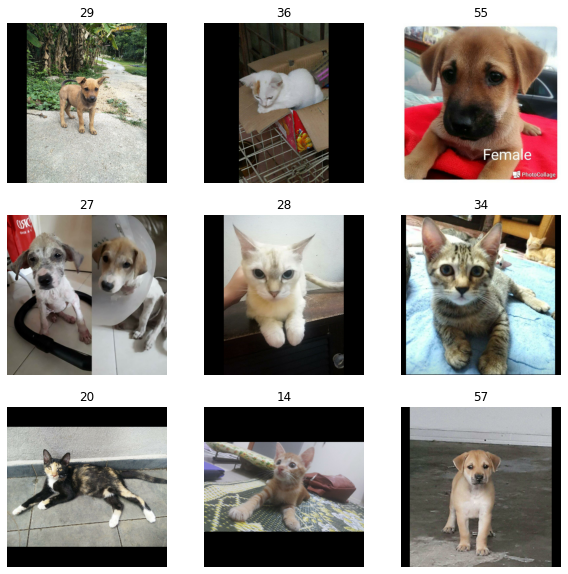

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in ds_train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy())
    plt.title(str(labels[i].numpy()))
    plt.axis("off")

### EfficientNet with MLP

In [ ]:
IMAGE_HEIGHT, IMAGE_WIDTH = img_size[0], img_size[1]
efficientNetB4 = tf.keras.applications.EfficientNetB4(
    include_top=False, weights='imagenet',
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), pooling='avg'
)

In [ ]:
model1 = tf.keras.Sequential([
  tf.keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH,3)),
  data_augmentation,
  efficientNetB4,
  layers.Dropout(0.3),
  tf.keras.layers.BatchNormalization(),
  layers.Dense(512, activation="elu"),
  layers.Dropout(0.2),
  tf.keras.layers.BatchNormalization(),
  layers.Dense(128, activation="elu"),
  layers.Dense(1)                     
])

In [ ]:
def my_rmse(y_true, y_pred):
    #difference between true label and predicted label
    error = 100 * (y_true - y_pred)    
    #square of the error
    sqr_error = tf.square(error)
    #mean of the square of the error
    mean_sqr_error = tf.keras.backend.mean(sqr_error)
    #square root of the mean of the square of the error
    sqrt_mean_sqr_error = tf.sqrt(mean_sqr_error)
    #return the error
    return sqrt_mean_sqr_error


In [ ]:
model1.load_weights("/content/drive/MyDrive/sjsu/255 project/code/zzj/EfficientNetB4_improved_fine_tune/efficientNet_fine_weights.hd5")
model1.compile(tf.keras.optimizers.Adam(),
            loss=my_rmse,
            metrics=[my_rmse])

In [ ]:
model1.save('/content/drive/MyDrive/sjsu/255 project/code/zzj/Final_Models/EfficientNetB4_Final.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
model1 = tf.keras.models.load_model('/content/drive/MyDrive/sjsu/255 project/code/zzj/Final_Models/EfficientNetB4_Final.h5', custom_objects={ 'my_rmse': my_rmse})

In [ ]:
c.evaluate(ds_test)

8/8 [==============================] - 16s 2s/step - loss: 21.5741 - my_rmse: 21.5492


[21.5740909576416, 21.54922103881836]

### Extract Intermidiate layer output

In [ ]:
model1.evaluate(ds_test)

8/8 [==============================] - 17s 2s/step - loss: 21.5741 - my_rmse: 21.5492


[21.5740909576416, 21.54922103881836]

In [ ]:
model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 380, 380, 3)       0         
                                                                 
 efficientnetb4 (Functional)  (None, 1792)             17673823  
                                                                 
 dropout_4 (Dropout)         (None, 1792)              0         
                                                                 
 batch_normalization_4 (Batc  (None, 1792)             7168      
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 512)               918016    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                      

In [ ]:
layer_name = 'dense_7'
intermediate_layer_model = tf.keras.Model(inputs=model1.input, outputs=model1.get_layer(layer_name).output)

In [ ]:
extracted_train = intermediate_layer_model.predict(ds_train)
extracted_val = intermediate_layer_model.predict(ds_val)
extracted_test = intermediate_layer_model.predict(ds_test)

In [ ]:
dense_vec = train_csv_df.drop(columns=['Id', 'img_path', 'Pawpularity'], axis=1)
X_dense_train, X_dense_test, y_dense_train, y_dense_test = train_test_split(dense_vec, train_csv_df['Pawpularity'], test_size=0.2, random_state=40)
X_dense_train, X_dense_val, y_dense_train, y_dense_val = train_test_split(X_dense_train, y_dense_train, test_size=0.15, random_state=40)

y_dense_train /= 100
y_dense_val /= 100
y_dense_test /= 100

new_x_train = np.hstack((extracted_train,X_dense_train))
new_x_val = np.hstack((extracted_val,X_dense_val))
new_x_test = np.hstack((extracted_test,X_dense_test))

In [ ]:
new_x_train.shape

(6739, 140)

In [ ]:
new_input_shape = new_x_train.shape[1]
model2 = tf.keras.Sequential([
  tf.keras.Input(shape=new_input_shape),
  layers.Dropout(0.2),
  tf.keras.layers.BatchNormalization(),
  layers.Dense(1024, activation="relu"),
  layers.Dropout(0.2),
  tf.keras.layers.BatchNormalization(),
  layers.Dense(512, activation="relu"),
  layers.Dropout(0.2),
  tf.keras.layers.BatchNormalization(),
  layers.Dense(256, activation="relu"),
  layers.Dropout(0.1),
  tf.keras.layers.BatchNormalization(),
  layers.Dense(64, activation="relu"),
  layers.Dropout(0.1),
  tf.keras.layers.BatchNormalization(),
  layers.Dense(1)                     
])

In [ ]:
model2.compile(optimizer="adam",
            loss=my_rmse,
            metrics=[my_rmse])

fpath = "/content/drive/MyDrive/sjsu/255 project/code/zzj/EfficientNetB4_improved/new_mlp_weights.hd5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
  filepath=fpath,
  save_weights_only=True,
  monitor='val_my_rmse',
  mode='min',
  save_best_only=True)

history2 = model2.fit(x=new_x_train, y=y_dense_train, epochs=100, batch_size=2048,validation_data=(new_x_val, y_dense_val), callbacks=[model_checkpoint_callback])

Epoch 1/100
4/4 [==============================] - 2s 244ms/step - loss: 129.7432 - my_rmse: 127.2896 - val_loss: 61.0240 - val_my_rmse: 61.0240
Epoch 2/100
4/4 [==============================] - 0s 55ms/step - loss: 104.2398 - my_rmse: 103.4593 - val_loss: 58.0016 - val_my_rmse: 58.0016
Epoch 3/100
4/4 [==============================] - 0s 56ms/step - loss: 91.8366 - my_rmse: 91.0457 - val_loss: 50.2014 - val_my_rmse: 50.2014
Epoch 4/100
4/4 [==============================] - 0s 66ms/step - loss: 85.5652 - my_rmse: 84.5415 - val_loss: 41.9334 - val_my_rmse: 41.9334
Epoch 5/100
4/4 [==============================] - 0s 53ms/step - loss: 79.4826 - my_rmse: 79.5773 - val_loss: 35.9126 - val_my_rmse: 35.9126
Epoch 6/100
4/4 [==============================] - 0s 55ms/step - loss: 74.5606 - my_rmse: 74.5679 - val_loss: 30.9677 - val_my_rmse: 30.9677
Epoch 7/100
4/4 [==============================] - 0s 61ms/step - loss: 71.4483 - my_rmse: 70.9173 - val_loss: 28.1398 - val_my_rmse: 28.1398
E

In [ ]:
np.save(f"/content/drive/MyDrive/sjsu/255 project/code/zzj/EfficientNetB4_improved/new_mlp_hist.npy", history2.history)

In [ ]:
model2.load_weights("/content/drive/MyDrive/sjsu/255 project/code/zzj/EfficientNetB4_improved/new_mlp_weights.hd5")

In [ ]:
intermediate_layer_model.save('/content/drive/MyDrive/sjsu/255 project/code/zzj/Final_Models/EfficientNetB4_Intermidiate_Final.h5')
model2.save('/content/drive/MyDrive/sjsu/255 project/code/zzj/Final_Models/EfficientNetB4_Mlp_Final.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
effcientNetB4_mlp.evaluate(new_x_test, y_dense_test)

62/62 [==============================] - 0s 3ms/step - loss: 21.0034 - my_rmse: 21.0034


[21.00341796875, 21.00335693359375]

In [ ]:
model2.save('/content/drive/MyDrive/sjsu/255 project/code/zzj/Final_Models/EfficientNetB4_Mlp_Final.h5')

### Plotting

In [ ]:
def plot_train_val_loss(history):
  plt.plot(history['loss'], label='training_loss')
  plt.plot(history['val_loss'], label = 'val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

def plot_train_val_acc(history):
  plt.plot(history['my_rmse'], label='training_my_rmse')
  plt.plot(history['val_my_rmse'], label = 'val_rmse')
  plt.xlabel('Epoch')
  plt.ylabel('RMSE')
  plt.legend()

def load_hist(model_name):
  history = np.load(f'/content/drive/MyDrive/Colab Notebooks/Data255_ass1_files/{model_name}/{model_name}_history.npy',allow_pickle='TRUE').item()
  return history

In [ ]:
mlp_hist = np.load("/content/drive/MyDrive/sjsu/255 project/code/zzj/EfficientNetB4_improved/new_mlp_hist.npy",allow_pickle='TRUE').item()
eff_hist = np.load("/content/drive/MyDrive/sjsu/255 project/code/zzj/EfficientNetB4_improved/efficientB4_hist.npy",allow_pickle='TRUE').item()

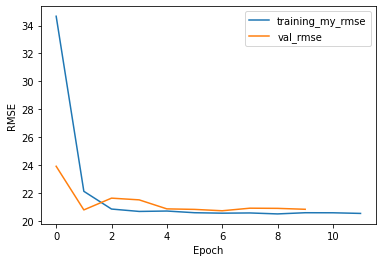

In [ ]:
plot_train_val_acc(eff_hist)

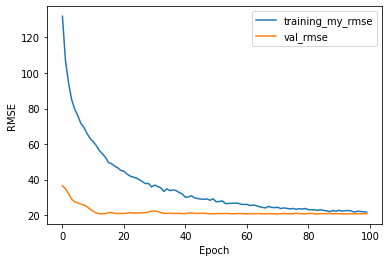

In [ ]:
plot_train_val_acc(mlp_hist)

### Evaluation

In [27]:
from sklearn.metrics import mean_squared_error

In [21]:
trans_effb4 = tf.keras.models.load_model('/content/drive/MyDrive/sjsu/255 project/code/zzj/Final_Models/EfficientNetB4_Final.h5', custom_objects={ 'my_rmse': my_rmse})
intermidate_denes = tf.keras.models.load_model('/content/drive/MyDrive/sjsu/255 project/code/zzj/Final_Models/EfficientNetB4_Intermidiate_Final.h5', custom_objects={ 'my_rmse': my_rmse})
trans_effb4_mlp = tf.keras.models.load_model('/content/drive/MyDrive/sjsu/255 project/code/zzj/Final_Models/EfficientNetB4_Mlp_Final.h5', custom_objects={ 'my_rmse': my_rmse})

In [23]:
extracted_test = intermidate_denes.predict(ds_test)
dense_vec = train_csv_df.drop(columns=['Id', 'img_path', 'Pawpularity'], axis=1)
X_dense_train, X_dense_test, y_dense_train, y_dense_test = train_test_split(dense_vec, train_csv_df['Pawpularity'], test_size=0.2, random_state=40)
new_x_test = np.hstack((extracted_test,X_dense_test))

In [25]:
trans_effb4_pred = trans_effb4.predict(ds_test) * 100
trans_effb4_mlp_pred = trans_effb4_mlp.predict(new_x_test) * 100

In [30]:
trans_effb4_rmse = mean_squared_error(y_dense_test, trans_effb4_pred, squared=False)
trans_effb4_mlp_rmse = mean_squared_error(y_dense_test, trans_effb4_mlp_pred , squared=False)

trans_effb4_mse = mean_squared_error(y_dense_test, trans_effb4_pred)
trans_effb4_mlp_mse = mean_squared_error(y_dense_test, trans_effb4_mlp_pred)

In [36]:
print(f"RMSE for Transfer Learning EfficientNetB4 Based Model: {round(trans_effb4_rmse, 4)}")
print(f"RMSE for Feature Extraction MLP Model: {round(trans_effb4_mlp_rmse, 4)}")


print(f"MSE for Transfer Learning EfficientNetB4 Based Model: {round(trans_effb4_mse, 4)}")
print(f"MSE for Feature Extraction MLP Model: {round(trans_effb4_mlp_mse, 4)}")

RMSE for Transfer Learning EfficientNetB4 Based Model: 21.585
RMSE for Feature Extraction MLP Model: 21.0034
MSE for Transfer Learning EfficientNetB4 Based Model: 465.9102
MSE for Feature Extraction MLP Model: 441.1428
